<h1> Captsone Project - The Battle Of Neighbourhoods - Live in Montreal </h1>

<h2> Introduction/Business Problem </h2>

Montreal, the 2nd most populated city in Canada has more than 4 millions population with a slow growth of 0.73% average every year. Montreal is also known as the 2nd largest economy in Canada by having a variety of businesses implementing themselves out there. As the nest of opportunities, many big tech companies started considering the city to have new offices - Google, Facebook, Microsoft to name a few. 

In the case where an individual had to relocate for a job opportunity, what would be the best locations we could suggest him? The purpose of this report is to identify what would be the best options through a data driven research. We will identify amneties and venues based on their ratings from which we will offer options based on the relocator preferences.

This project targets mostly individuals that are not familiar with the city and that are searching a convenient borough where they can live. It will bring also options that fit the individual interest. As an example, an individual in the need of relocating, who likes parks, we expect him willing to be close to that type of venue.

<h2> Data Description </h2>

Data :<br>

- Montreal city boroughs names with their coordinates (latitude and longitude).
    - Data pulled from Wikipedia with the BeautifulSoup library. Alternatively, we could manually put the data in a CSV file.
    - Will be used with Foursquare API data to define the best venues of each boroughs.
    - We will use Folium to vizualize the different boroughs within Montreal.

- Top 10 venues based on ratings, which include their type(e.g : Restaurants, Bars, Malls, Parks, etc.) and their location (latitude and logitude).
    - For each 32 neighborhoods of Montreal. 
    - Clustering process with K-Mean algorithm to define more precisely where good venues and amneties are.
    - Data will be visualized on a folium generated map.
    - Will use the panda library to analyze and organize the data.

- Criminality data of Montreal (the last 6 months of 2020)
    - Pulled from the Montreal City website.
    - Includes type of criminal events(For more insights).
    - Data will be visualized on a folium generated map.
    - Correlation matrix will be analysed against other datasets available.
    - Will use the panda library to analyze and organize the data.

- Demographic census of Montreal
    - Data covering population, density and real estate prices.
    - While the census available is stale(data from 2016), we can correlate and put in perspective the results.
    - Data will be visualized on a folium generated map.
    - Correlation matrix will be analysed against datasets available.

How : 

- Several platform and techniques will be used during this report.
    - Python as the interpreter language. As R, extensively used in the Data analytic field. Useful for the diversity of libraries.
    - Geocoders to convert addresses into coordinates.
    - Pandas for dataframe manipulation.
    - Folium for map visualization with our point of interest(Neighborhoods and venues).
    - Foursquare offers an API giving access to a wide range of data related to locations.
    - As a clustering algorithm, K-Mean will be used to define ideal locations. Sklearn library helps for that purpose.



<h3>Lets start by preloading a list of libraries utilized in this project<h3>

In [1]:
from bs4 import BeautifulSoup
import pandas as pd
from geopy.geocoders import Nominatim
import geocoder
import numpy as np
import json
from re import search
import re
import requests
import matplotlib.pyplot as plt
import unidecode
import seaborn as sns
#import branca.colormap as cm
#from io import StringIO
import folium
import seaborn as sn
#import matplotlib.cm as cm
#import matplotlib.colors as colors
from sklearn.cluster import KMeans
#from sklearn.preprocessing import OneHotEncoder
#from sklearn.metrics import silhouette_score
#from sklearn.datasets import make_blobs
#from sklearn.preprocessing import StandardScaler
#from yellowbrick.cluster import KElbowVisualizer
from folium import plugins
from folium.plugins import HeatMap

<h3>We load the GoogleApi credentials and FoursquareApi credentials.</h3>

In [2]:

with open('Credentials.json') as f:
    data = json.load(f)
    MyGoogleAPIKey = data['MyGoogleAPIKey']
    CLIENT_ID = data['CLIENT_ID']
    CLIENT_SECRET = data['CLIENT_SECRET']
VERSION = '20180605'


<h3>Function makes a request to the Google Maps Api with an address passed in arg.<br>
 Return the latitude and longitude of the address</h3>

In [3]:
def get_coordinates(api_key, address, verbose=False):
    try:
        url = 'https://maps.googleapis.com/maps/api/geocode/json?key={}&address={}'.format(api_key, address)
        response = requests.get(url).json()
        if verbose:
            print('Google Maps API JSON result =>', response)
        results = response['results']
        geographical_data = results[0]['geometry']['location']
        lat = geographical_data['lat']
        lon = geographical_data['lng']
        return [lat, lon]
    except:
        return [None, None]

<h3>Function taken from a previous lab of the curriculum.<br> 
It pulls a list of venues @ certain RADIUS of the lat/long past in arg.<br> 
We limit ourselves with #LIMIT records per lat/long.<br> 
The function will not be used just yet.</h3>

In [4]:
def getNearbyVenues(names, latitudes, longitudes, radius=5000,LIMIT=200):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)

        results = requests.get(url).json()["response"]['groups'][0]['items']

        venues_list.append([(
            name, 
            lat, 
            lng,
            v['venue']['id'], 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'ID',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

<h3>We will use the geojson of Montreal(Found @ https://jmacman12.carto.com/tables/montreal_shapefile/public) which include the shape of all boroughs and towns.<br>
This geojson will serve as a baseline of boroughs(& towns) of Montreal city. This baseline will help on standardizing other datasets in this project.<br>
Boroughs is standadized by removing accents and lower casing the string value.</h3>

In [5]:
geojson = open('MontrealGeoShape.geojson', 'r',encoding="utf-8")
geojson = geojson.read()
geojson = json.loads(geojson)
for x in geojson['features']:
    x['properties']['district'] = unidecode.unidecode(x['properties']['district']).lower()

<h3>We load a "handcrafted" file of Montreal boroughs&town from Wikipedia<br>
We standardize the values to fit the geojson file loaded earlier<br>
For the missing towns/boroughs, we add them to the DF and call the GoogleApi for Lat/Long values.<h3>

In [6]:
dfMtlPos = pd.read_csv('MontrealBoroughsLatLong.csv')
for x,row in enumerate(dfMtlPos.iterrows()) :
    dfMtlPos.at[x,"Boroughs"] = unidecode.unidecode(dfMtlPos.at[x,"Boroughs"].lower())
    if dfMtlPos.at[x,"Boroughs"] == "southwest":
        dfMtlPos.at[x,"Boroughs"] = "le sud-ouest"
    if dfMtlPos.at[x,"Boroughs"] == "cote saint-luc":
        dfMtlPos.at[x,"Boroughs"] = "cote-saint-luc"
    if dfMtlPos.at[x,"Boroughs"] == "baie-d'urfe":
        dfMtlPos.at[x,"Boroughs"] = "baie d'urfe"
for x in geojson['features']:
    if x['properties']['district'] not in dfMtlPos['Boroughs'].values:
        latlong = get_coordinates(MyGoogleAPIKey,x['properties']['district'],verbose=False)
        dfMtlPos = dfMtlPos.append({'Boroughs': x['properties']['district'],'Type': 'T','Lat':latlong[0],'Long':latlong[1]},ignore_index=True)

<h3>Lets see the 33 Boroughs and Towns of Montreal. <br> 
Note the Type values that distinguish them.<h3>

In [7]:
dfMtlPos

Boroughs Type        Lat       Long
0                        pierrefonds-roxboro    B  45.509630 -73.819152
1        cote-des-neiges-notre-dame-de-grace    B  45.491151 -73.632653
2              mercier-hochelaga-maisonneuve    B  45.572978 -73.530795
3                                     verdun    B  45.454827 -73.569873
4                                    lasalle    B  45.430627 -73.634801
5                                ville-marie    B  45.508794 -73.555302
6                                    lachine    B  45.441347 -73.688585
7                              saint-laurent    B  45.498564 -73.749757
8                              saint-leonard    B  45.587473 -73.597010
9                               le sud-ouest    B  45.466107 -73.593866
10                                 outremont    B  45.514286 -73.609011
11                             montreal-nord    B  45.607198 -73.631474
12                 rosemont-la petite-patrie    B  45.551702 -73.583627
13                                mont-royal    B  45.507102 -73.587407
14                     ahuntsic-cartierville    B  45.544743 -73.668126
15             l'ile-bizard-sainte-genevieve    B  45.494889 -73.890756
16                                     anjou    B  45.615958 -73.569351
17  riviere-des-prairies-pointe-aux-trembles    B  45.673073 -73.518665
18      villeray-saint-michel-parc-extension    B  45.555334 -73.608310
19                            cote-saint-luc    T  45.468050 -73.672946
20                              beaconsfield    T  45.430931 -73.868283
21                                    dorval    T  45.450321 -73.750049
22                             pointe-claire    T  45.471966 -73.799019
23                                 westmount    T  45.485719 -73.595699
24                                  kirkland    T  45.456041 -73.862334
25                               baie d'urfe    T  45.416456 -73.916080
26                              montreal-est    T  45.632000 -73.506698
27                   sainte-anne-de-bellevue    T  45.403276 -73.950361
28                       dollard-des-ormeaux    T  45.489564 -73.820557
29                     le plateau-mont-royal    T  45.523153 -73.587043
30                                 hampstead    T  51.555646  -0.176175
31                            montreal-ouest    T  45.454725 -73.650236
32                                senneville    T  45.441342 -73.954872

<h3>Let's go over our DF and pull a set of venues @ #RADIUS (defined in meters).<br>
 Let's see the output.<h3>

In [8]:
dfMtlVenues = getNearbyVenues(names=dfMtlPos['Boroughs'],latitudes=dfMtlPos['Lat'],longitudes=dfMtlPos['Long'])
#Archive === dfMtlVenues = pd.read_csv("MontrealVenus.csv")
##Let's have a look at it.
dfMtlVenues

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0     pierrefonds-roxboro              45.509630              -73.819152   
1     pierrefonds-roxboro              45.509630              -73.819152   
2     pierrefonds-roxboro              45.509630              -73.819152   
3     pierrefonds-roxboro              45.509630              -73.819152   
4     pierrefonds-roxboro              45.509630              -73.819152   
...                   ...                    ...                     ...   
2886           senneville              45.441342              -73.954872   
2887           senneville              45.441342              -73.954872   
2888           senneville              45.441342              -73.954872   
2889           senneville              45.441342              -73.954872   
2890           senneville              45.441342              -73.954872   

                            ID                       Venue  Venue Latitude  \
0     4bdb01a53904a593993d489e  Restaurant Bombay Choupati       45.508404   
1     51313bfee4b098c263c5d332                 Les 3 Maria       45.504460   
2     4c49c15c3013a59398152de3                Shahi Palace       45.503766   
3     51411f87e4b091a07e3025ce               Chateau Kebab       45.502341   
4     4b65c853f964a5206eff2ae3               Allo Mon Coco       45.521944   
...                        ...                         ...             ...   
2886  4d07ab9537036dcb09fc22fb           Tandoori Bellevue       45.403280   
2887  4d41a6f9c5eaa1cd3af3ac50                      Basile       45.403086   
2888  4da38c442939b1f7f2b92057                 Couche-Tard       45.436828   
2889  4b71df1cf964a52068612de3                 Hwy 40 west       45.418365   
2890  4d41e5f21da9a0938bb45c3d              Bureau en Gros       45.442603   

      Venue Longitude                 Venue Category  
0          -73.820454              Indian Restaurant  
1          -73.817805          Portuguese Restaurant  
2          -73.816520              Indian Restaurant  
3          -73.815488      Middle Eastern Restaurant  
4          -73.799609                 Breakfast Spot  
...               ...                            ...  
2886       -73.950303              Indian Restaurant  
2887       -73.950543                   Burger Joint  
2888       -73.897979              Convenience Store  
2889       -74.004722                          Trail  
2890       -73.891743  Paper / Office Supplies Store  

[2891 rows x 8 columns]

<h3>Let's have a count per Neighborhood.<br>
We will only retain the neighborhood column and create a count of each occurence. <h3>

In [9]:
dfMtlVenuesCount = dfMtlVenues.groupby(['Venue Category','Neighborhood']).size()
dfMtlVenuesCount.columns = ['Venue Category	','Neighborhood', 'Count']
dfMtlVenuesCount.sort_values( ascending=False)
dfMtlVenuesCount = dfMtlVenuesCount.to_frame().reset_index()
dfMtlVenuesCount = dfMtlVenuesCount.groupby(['Neighborhood']).size()
dfMtlVenuesCount = dfMtlVenuesCount.to_frame().reset_index()
dfMtlVenuesCount.columns = ['Neighborhood', 'Total']
#dfMtlVenuesCountPerNeighborhood.sort_values(ascending=False, by=['Total'], inplace=True)
dfMtlVenuesCount

Neighborhood  Total
0                      ahuntsic-cartierville     54
1                                      anjou     41
2                                baie d'urfe     32
3                               beaconsfield     49
4        cote-des-neiges-notre-dame-de-grace     59
5                             cote-saint-luc     50
6                        dollard-des-ormeaux     44
7                                     dorval     47
8                                  hampstead     59
9                                   kirkland     47
10             l'ile-bizard-sainte-genevieve     33
11                                   lachine     38
12                                   lasalle     47
13                     le plateau-mont-royal     55
14                              le sud-ouest     55
15             mercier-hochelaga-maisonneuve     57
16                                mont-royal     51
17                              montreal-est     30
18                             montreal-nord     31
19                            montreal-ouest     50
20                                 outremont     55
21                       pierrefonds-roxboro     43
22                             pointe-claire     48
23  riviere-des-prairies-pointe-aux-trembles     24
24                 rosemont-la petite-patrie     51
25                             saint-laurent     47
26                             saint-leonard     51
27                   sainte-anne-de-bellevue     28
28                                senneville     26
29                                    verdun     59
30                               ville-marie     52
31      villeray-saint-michel-parc-extension     53
32                                 westmount     60

<h3>
We will display on a map the spread of venues within the boroughs of Montreal. <br>
We re-use a chropleth function obtained during the curriculum. <br>
A color argument is added to easily re-use the function throughout the analysis.<br>
We load our geojson data and our venues count DF. <br>
<h3>

In [10]:
center = [45.5017,-73.5673]

def show_choropleth_map(geo_data, dataframe, columns, legend_name, color):
    map = folium.Map(location=(center[0], center[1]), zoom_start=11)
    folium.TileLayer('cartodbpositron').add_to(map)
    folium.Choropleth(
        geo_data=geo_data,
        data=dataframe,
        columns=columns,
        key_on='feature.properties.district',
        fill_color=color,
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=legend_name
    ).add_to(map)

    return map


  
map = show_choropleth_map(geo_data=geojson,
                     dataframe=dfMtlVenuesCount,
                     columns=['Neighborhood', 'Total'],
                     legend_name='Venues',
                     color='YlGn'
                     )
plugins.ScrollZoomToggler().add_to(map)
map

<h3>
Turns out well on the map for all our 33 boroughs.<br>
It is good to mention that an overlap of venues can occur(neighborhoods sharing the same venues).<br>
Some neighborhoods also have venues out the island(since the api return venues within 5000 meters).
<h3>

<h3>
Top and bottom 5 of our dataset. The top are observable at the heart of Montreal.
The bottom are mostly at the edge of the Island.<br>
<h3>

In [11]:
print(dfMtlVenuesCount.sort_values('Total',ascending=False).head(5))
print(dfMtlVenuesCount.sort_values('Total',ascending=True).head(5))

                           Neighborhood  Total
32                            westmount     60
8                             hampstead     59
29                               verdun     59
4   cote-des-neiges-notre-dame-de-grace     59
15        mercier-hochelaga-maisonneuve     57
                                Neighborhood  Total
23  riviere-des-prairies-pointe-aux-trembles     24
28                                senneville     26
27                   sainte-anne-de-bellevue     28
17                              montreal-est     30
18                             montreal-nord     31


<h3>
Lets see the all the individual venues on that same map.
To observe the spread of the venues. It's here we confirm the presence 
of venues outside the island. <br>
<h3>

In [12]:
loc = 'Montreal Boroughs'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc)
map = folium.Map(location=[45.5017, -73.5673], zoom_start=11)
def style_function(feature):
    return { 'color': 'darkblue', 'fillOpacity': 0.2, }

map.get_root().html.add_child(folium.Element(title_html))
plugins.ScrollZoomToggler().add_to(map)
folium.GeoJson("MontrealGeoShape.geojson", style_function=style_function, name='geojson').add_to(map)

#Add venues to map        
for borough,lat,long in zip(dfMtlVenues['Venue'],dfMtlVenues['Venue Latitude'],dfMtlVenues['Venue Longitude']):
    label = folium.Popup(borough, parse_html=True)
    color='red'
    folium.CircleMarker(
        [lat, long],
        radius=1,
        popup=label,
        color=color,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.3,
        parse_html=False).add_to(map) 
map

<h3>
Have venues records and venues categories transposed then grouped by neighborhood.
We will define average of all venues category across an observation/row representing each neighborhood.
This will be done by creating a new df and use the get_dummies. We will add back the neighborhood column.
<h3>

In [13]:
dfMtlVenuesTranspose = pd.get_dummies(dfMtlVenues[['Venue Category']], prefix="", prefix_sep="")
dfMtlVenuesTranspose['Neighborhood'] = dfMtlVenues['Neighborhood']
dfMtlVenuesTranspose = dfMtlVenuesTranspose[([dfMtlVenuesTranspose.columns[-1]] + list(dfMtlVenuesTranspose.columns[:-1]))]
#print(type(dfMtlVenuesTranspose.groupby('Neighborhood')))
dfMtlGroupedVenues = dfMtlVenuesTranspose.groupby('Neighborhood').sum().reset_index()

<h3>
Small view of the averages.
<h3>

In [14]:
dfMtlGroupedVenues.head(5)

Neighborhood  African Restaurant  Airport  \
0                ahuntsic-cartierville                   0        0   
1                                anjou                   0        0   
2                          baie d'urfe                   0        0   
3                         beaconsfield                   0        0   
4  cote-des-neiges-notre-dame-de-grace                   0        0   

   Airport Lounge  Airport Service  American Restaurant  Art Gallery  \
0               0                0                    0            0   
1               0                0                    1            0   
2               0                0                    1            0   
3               0                0                    1            1   
4               0                0                    0            1   

   Art Museum  Arts & Crafts Store  Asian Restaurant  ...  \
0           0                    0                 1  ...   
1           0                    1                 0  ...   
2           0                    0                 0  ...   
3           0                    0                 0  ...   
4           1                    0                 0  ...   

   Transportation Service  Turkish Restaurant  Vegetarian / Vegan Restaurant  \
0                       0                   0                              0   
1                       0                   0                              0   
2                       0                   0                              0   
3                       0                   0                              0   
4                       0                   0                              1   

   Vietnamese Restaurant  Warehouse Store  Wine Bar  Wine Shop  Yoga Studio  \
0                      0                0         1          0            0   
1                      1                1         0          0            0   
2                      0                0         0          0            0   
3                      1                0         0          0            0   
4                      3                0         0          0            1   

   Zoo  Zoo Exhibit  
0    0            0  
1    0            0  
2    1            0  
3    0            0  
4    0            0  

[5 rows x 200 columns]

<h3>
Here's another function pulled from the curriculum which defines the x top venues for all the neighborhoods.
<h3>

In [15]:
num_top_venues = 15
indicators = ['st', 'nd', 'rd']
def fTopVenues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = dfMtlGroupedVenues['Neighborhood']

for ind in np.arange(dfMtlGroupedVenues.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = fTopVenues(dfMtlGroupedVenues.iloc[ind, :], num_top_venues)

#neighborhoods_venues_sorted

<h3>
This small function was used as part of our crime dataset adjustements. With lat and long values, it returns
an address.
<h3>

In [16]:
def fGeoToAddr(lat,long):
    geolocator = Nominatim(user_agent="https")
    return geolocator.reverse(str(lat)+","+str(long))

<h3>
All the following was commented since we've done all manipulations required on the original data, which
we then saved. We load our new file instead.
<h3>

<h3>
Overall, timestamp is converted to data and sort is performed on this column. Only the last 6 months of 2020 is taken
from the dataset. The long lat columns are simplified and we drop other columns which we will not use as part
of the analysis. Even if we filter only 6months of data, we insure we keep only 1000 records. We create an address column
which uses the function above. We then prepare the Neighborhood field which we will fill up with our postal code Wiki scraping.
<h3>

In [17]:
# testdfMtlCrime = pd.read_csv("MontrealCriminality.csv", encoding="ISO-8859-1")
# testdfMtlCrime['DATE'] = pd.to_datetime(testdfMtlCrime['DATE'])
# testdfMtlCrime.sort_values('DATE',inplace=True,ascending=False)
# testdfMtlCrime = testdfMtlCrime[(testdfMtlCrime['DATE'] > '2020-06-30') & (testdfMtlCrime['DATE'] < '2020-12-31')]
# testdfMtlCrime.rename(columns={'LONGITUDE':'long','LATITUDE':'lat'}, inplace=True)
# testdfMtlCrime.drop(['PDQ','X','Y'], axis=1, inplace=True)
# testdfMtlCrime = testdfMtlCrime[testdfMtlCrime.long != 1]
# testdfMtlCrime['Address'] = ""
# testdfMtlCrime.reset_index(inplace=True,drop=True)
# testdfMtlCrime['Neighborhood'] = ""
# for index,row in enumerate(testdfMtlCrime.iterrows()):
#     testdfMtlCrime.at[index,"Address"] = fGeoToAddr(row[1][4],row[1][3])
#     print(index,row[1][4],row[1][3], testdfMtlCrime.at[index,"Address"] )
#dfMtlCrime.to_csv('MontrealCrimesPerNeighboord.csv')
dfMtlCrime = pd.read_csv("MontrealCrimesV2.csv", encoding="utf-8")
dfMtlCrime= dfMtlCrime.drop('Unnamed: 0',axis=1)
dfMtlCrime.reset_index(inplace=True,drop=True)

In [18]:
#dfMtlCrime.shape
#dfMtlCrime[dfMtlCrime['CATEGORIE'].str.contains("mort")]
#testdfMtlCrime.to_csv('MontrealCrimesV2.csv')

<h3>
This section covers a webscrapping done on the Wikipedia page of the Canadian postal
code starting by "H". Those postal code cover the Montreal island and a few other
neighborhoods outside the island. A dictionnary is built with the web scrapping records
and we interogate our dataframe address field to define the right neighborhood associated
with the crime record.
<h3>

In [19]:
%%capture
r = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_H")
soup = BeautifulSoup(r.content)
dictPostalCode = {} 
for link in soup.find_all('td'):
    if link.find('a') != None and link.find('b') != None :
        dictPostalCode[link.find('b').text] = link.find('a').text

for index,row in enumerate(dfMtlCrime.iterrows()):
    if 'Baie-D\'Urfé' in dfMtlCrime['Address'][index]:
        dfMtlCrime['Neighborhood'][index] = 'baie d\'urfe'
    else:
        for record in str(dfMtlCrime['Address'][index]).split(','):
            if re.match(r'^H[0-9](?i)[a-z]\s?[0-9](?i)[a-z][0-9]$', record.strip()):
                if len(record.strip().split(" ")) == 1:
                    dfMtlCrime['Neighborhood'][index] = dictPostalCode[record.strip()[0:3]]
                else:
                    if record.strip().split(" ")[0] == 'H6N':
                        dfMtlCrime['Neighborhood'][index] = 'lasalle'
                    else:
                        dfMtlCrime['Neighborhood'][index] = dictPostalCode[record.strip().split(" ")[0]]
            elif re.match(r'^H[0-9](?i)[a-z]$', record.strip()):
                dfMtlCrime['Neighborhood'][index] = dictPostalCode[record.strip()[0:3]]
#dfMtlCrime = dfMtlCrime[dfMtlCrime.Neighborhood != 'NaN']
#dfMtlCrime[dfMtlCrime.Neighborhood == 'NaN']
dfMtlCrime.dropna(inplace=True)

#for index,row in enumerate(dfMtlCrime.iterrows()):
        #if re.match(r'^(?i)[a-z][0-9](?i)[a-z]\s?[0-9](?i)[a-z][0-9]$', record.strip()):
        #if dfMtlCrime['Address'][index] == 'nan':
        #     print(dfMtlCrime.Address[index])
            #dfMtlCrime.drop([dfMtlCrime.index[index]], inplace=True)
        #     dfMtlCrime.reset_index(inplace=True,drop=True)
            #index=index+1
            #print(dfMtlCrime.Address[index])
    #print('done')
#dfMtlCrime = dfMtlCrime[dfMtlCrime.Neighborhood.str.contains('NaN')]

<h3>
Let's see how the Neighborhood is populated accross our dataframe.
<h3>

In [20]:
dfMtlCrime.shape
dfMtlCrime
#dfMtlCrime.Neighborhood[9668]

CATEGORIE        DATE QUART       long  \
0              Vol de véhicule à moteur  2020-12-30  jour -73.606116   
1                        Vols qualifiés  2020-12-30  soir -73.643600   
2              Vol de véhicule à moteur  2020-12-30  soir -73.630988   
3              Vol de véhicule à moteur  2020-12-30  soir -73.556088   
4      Vol dans / sur véhicule à moteur  2020-12-30  jour -73.598630   
...                                 ...         ...   ...        ...   
11299          Vol de véhicule à moteur  2020-07-01  nuit -73.689990   
11300                      Introduction  2020-07-01  nuit -73.598965   
11301                            Méfait  2020-07-01  jour -73.573475   
11302          Vol de véhicule à moteur  2020-07-01  nuit -73.632684   
11303          Vol de véhicule à moteur  2020-07-01  jour -73.550044   

             lat                                            Address  \
0      45.591296  8920, Rue Claudel, Port-Maurice, Saint-Léonard...   
1      45.516926  1250, Boulevard Laird, Mont-Royal, Agglomérati...   
2      45.596898  11135, Avenue Bellevois, Montreal-Nord-Centre,...   
3      45.550912  3801, Place Victor Bourgeau, Petite-Côte, Rose...   
4      45.564641  7453, 17e Avenue, Villeray, Villeray–Saint-Mic...   
...          ...                                                ...   
11299  45.508527  1995, Boulevard de la Côte-Vertu, Bois-Francs,...   
11300  45.625453  7515, Boulevard Maurice-Duplessis, Marc-Aurèle...   
11301  45.534077  du Mont-Royal / Chabot, Avenue du Mont-Royal E...   
11302  45.604122  École Louis Fréchette, Boulevard Sainte-Gertru...   
11303  45.549093  3866, Rue Hochelaga, Hochelaga, Mercier–Hochel...   

               Neighborhood  
0             Saint-Léonard  
1               Mount Royal  
2             Montréal-Nord  
3                  Rosemont  
4              Saint-Michel  
...                     ...  
11299         Saint-Laurent  
11300  Rivière-des-Prairies  
11301    Plateau Mont-Royal  
11302         Montréal-Nord  
11303             Hochelaga  

[11294 rows x 7 columns]

<h3>
As we've done with venues, we created columns from the crime categories, we create a total column from the counts of the different categories.
We translated the categories in english. Standardization and some merging operations were done to make the data fit with other datasets.
<h3>

In [21]:
dfDummyCrime = pd.get_dummies(dfMtlCrime[['CATEGORIE']], prefix="", prefix_sep="")
dfDummyCrime['Neighborhood'] = dfMtlCrime['Neighborhood']
dfDummyCrime = dfDummyCrime[([dfDummyCrime.columns[-1]] + list(dfDummyCrime.columns[:-1]))]
dfDummyCrime = dfDummyCrime.groupby(['Neighborhood']).sum()
dfDummyCrime["Total"] = dfDummyCrime["Introduction"] + dfDummyCrime["Méfait"] + dfDummyCrime["Vol dans / sur véhicule à moteur"] + dfDummyCrime["Vol de véhicule à moteur"] + dfDummyCrime["Vols qualifiés"]

dfDummyCrime.rename({"Infractions entrainant la mort":"Offense causing death","Introduction":"Break in","Méfait":'Mischief',"Vol dans / sur véhicule à moteur":'Robbery involving vehicule',"Vol de véhicule à moteur":'Robbery of Vehicule',"Vols qualifiés":'Armed Robbery'}, inplace=True,axis='columns',errors="raise")
dfDummyCrime.reset_index(inplace=True, drop=False)

dfDummyCrime = dfDummyCrime.transpose()
dfDummyCrime.columns = dfDummyCrime.iloc[0]
dfDummyCrime = dfDummyCrime.iloc[1:]
dfDummyCrime.columns = [x.lower() for x in dfDummyCrime.columns]
dfDummyCrime.columns = [unidecode.unidecode(x) for x in dfDummyCrime.columns]
print(dfDummyCrime)
dfDummyCrime['cote-des-neiges-notre-dame-de-grace'] = dfDummyCrime['cote-des-neiges'] + dfDummyCrime['notre-dame-de-grace']
dfDummyCrime['pierrefonds-roxboro'] = dfDummyCrime['pierrefonds-roxboro'] + dfDummyCrime['pierrefonds']
dfDummyCrime['mont-royal'] = dfDummyCrime['mount royal']
dfDummyCrime['le plateau-mont-royal'] = dfDummyCrime['plateau mont-royal']
dfDummyCrime["l'ile-bizard-sainte-genevieve"] = dfDummyCrime['l\'ile-bizard'] + dfDummyCrime['sainte-genevieve']
dfDummyCrime['le sud-ouest'] = dfDummyCrime['saint-henri'] + dfDummyCrime['ville emard'] + dfDummyCrime['pointe-saint-charles']
dfDummyCrime['lachine'] = dfDummyCrime['ville saint-pierre'] + dfDummyCrime['lachine'] + dfDummyCrime['petite-bourgogne'] + dfDummyCrime['griffintown']
dfDummyCrime['ahuntsic-cartierville'] = dfDummyCrime['ahuntsic'] + dfDummyCrime['cartierville']
dfDummyCrime['cote-saint-luc'] = dfDummyCrime['cote saint-luc']
dfDummyCrime['montreal-ouest'] = dfDummyCrime['montreal west']
dfDummyCrime['montreal-est'] = dfDummyCrime['montreal east']
dfDummyCrime['verdun'] = dfDummyCrime['verdun'] + dfDummyCrime['l\'ile-des-soeurs']
dfDummyCrime['rosemont-la petite-patrie'] = dfDummyCrime['petite-patrie'] + dfDummyCrime['rosemont']
dfDummyCrime['riviere-des-prairies-pointe-aux-trembles'] = dfDummyCrime['pointe-aux-trembles'] + dfDummyCrime['riviere-des-prairies']
dfDummyCrime['mercier-hochelaga-maisonneuve'] = dfDummyCrime['maisonneuve'] + dfDummyCrime['mercier'] + dfDummyCrime['hochelaga']
dfDummyCrime['villeray-saint-michel-parc-extension'] = dfDummyCrime['villeray'] + dfDummyCrime['saint-michel'] + dfDummyCrime['parc-extension']
dfDummyCrime['ville-marie'] = dfDummyCrime['downtown montreal'] + dfDummyCrime['old montreal'] + dfDummyCrime['centre-sud'] + dfDummyCrime['tour de la bourse']
dfDummyCrime.drop(['cote-des-neiges', 'notre-dame-de-grace','pierrefonds','plateau mont-royal','l\'ile-bizard','downtown montreal','ville emard','old montreal','centre-sud','villeray','saint-michel','parc-extension','maisonneuve','mercier','hochelaga','pointe-aux-trembles','riviere-des-prairies','petite-patrie','rosemont','l\'ile-des-soeurs','montreal east','montreal west','cote saint-luc','ahuntsic','cartierville','ville saint-pierre','petite-bourgogne','griffintown','saint-henri','ville emard','pointe-saint-charles','sainte-genevieve','mount royal','tour de la bourse','laval-sur-le-lac'], axis=1, inplace=True)
dfDummyCrime = dfDummyCrime.transpose()
dfDummyCrime = dfDummyCrime.reset_index()
dfDummyCrime = dfDummyCrime.rename({"index":"Neighborhood"},axis='columns',errors="raise")
dfDummyCrime.sort_values(ascending=False, by=['Total'], inplace=True)
#dfDummyCrime = dfDummyCrime.append(pd.DataFrame([['baie d\'urfe',0,0,0,0,0,0]], columns=dfDummyCrime.columns))
dfDummyCrime = dfDummyCrime.reset_index(drop=True)

                           ahuntsic  anjou beaconsfield cartierville  \
Offense causing death           3.0    1.0          0.0          1.0   
Break in                       96.0   23.0         10.0         29.0   
Mischief                       92.0   34.0          4.0         33.0   
Robbery involving vehicule    152.0  114.0          9.0         41.0   
Robbery of Vehicule           116.0   74.0          9.0         74.0   
Armed Robbery                  20.0    8.0          1.0         13.0   
Total                         476.0  253.0         33.0        190.0   

                           centre-sud cote saint-luc cote-des-neiges  \
Offense causing death             0.0            0.0             0.0   
Break in                        192.0           26.0            61.0   
Mischief                        159.0           32.0            82.0   
Robbery involving vehicule      132.0           21.0            77.0   
Robbery of Vehicule              41.0           21.0           

In [22]:
dfDummyCrime = dfDummyCrime.groupby('Neighborhood').sum()


<h3>
Lets group all crime counts per neighborhood and let's have sorted with the most total count of criminal activities
<h3>

In [23]:
dfDummyCrime.reset_index(inplace=True,drop=False)
dfDummyCrime.sort_values(ascending=False, by=['Total'], inplace=True)
dfDummyCrime

Neighborhood  Offense causing death  Break in  \
30                               ville-marie                    0.0     349.0   
15             mercier-hochelaga-maisonneuve                    2.0     268.0   
31      villeray-saint-michel-parc-extension                    0.0     256.0   
13                     le plateau-mont-royal                    0.0     317.0   
24                 rosemont-la petite-patrie                    0.0     240.0   
0                      ahuntsic-cartierville                    4.0     125.0   
25                             saint-laurent                    0.0     123.0   
11                                   lachine                    0.0     141.0   
4        cote-des-neiges-notre-dame-de-grace                    1.0     110.0   
18                             montreal-nord                    0.0      97.0   
23  riviere-des-prairies-pointe-aux-trembles                    2.0      58.0   
14                              le sud-ouest                    1.0     147.0   
26                             saint-leonard                    0.0      81.0   
29                                    verdun                    0.0      89.0   
1                                      anjou                    1.0      23.0   
12                                   lasalle                    0.0      52.0   
17                              montreal-est                    0.0      35.0   
7                                     dorval                    0.0      42.0   
20                                 outremont                    0.0      38.0   
6                        dollard-des-ormeaux                    0.0      32.0   
22                             pointe-claire                    0.0      22.0   
16                                mont-royal                    0.0      28.0   
32                                 westmount                    0.0      42.0   
21                       pierrefonds-roxboro                    0.0      30.0   
5                             cote-saint-luc                    0.0      26.0   
10             l'ile-bizard-sainte-genevieve                    0.0      39.0   
8                                  hampstead                    0.0      20.0   
9                                   kirkland                    0.0      23.0   
3                               beaconsfield                    0.0      10.0   
19                            montreal-ouest                    0.0       6.0   
28                                senneville                    0.0       4.0   
27                   sainte-anne-de-bellevue                    0.0       5.0   
2                                baie d'urfe                    0.0       4.0   

    Mischief  Robbery involving vehicule  Robbery of Vehicule  Armed Robbery  \
30     321.0                       360.0                 90.0           95.0   
15     250.0                       352.0                233.0           65.0   
31     194.0                       238.0                173.0           45.0   
13     214.0                       164.0                 83.0           54.0   
24     173.0                       204.0                168.0           41.0   
0      125.0                       193.0                190.0           33.0   
25      95.0                       141.0                135.0           20.0   
11     131.0                       143.0                 74.0           22.0   
4      136.0                       115.0                 80.0           41.0   
18      98.0                       120.0                119.0           24.0   
23     106.0                       126.0                126.0           13.0   
14     119.0                        90.0                 29.0           28.0   
26      70.0                       122.0                122.0           16.0   
29      97.0                        85.0                 35.0           14.0   
1       34.0                       114.0                 74.0            8.0 

<h3>
Graphical representation of the top5 and bottom5 of total crimes.
<h3>

Text(0.5, 0, 'Neighborhoods')

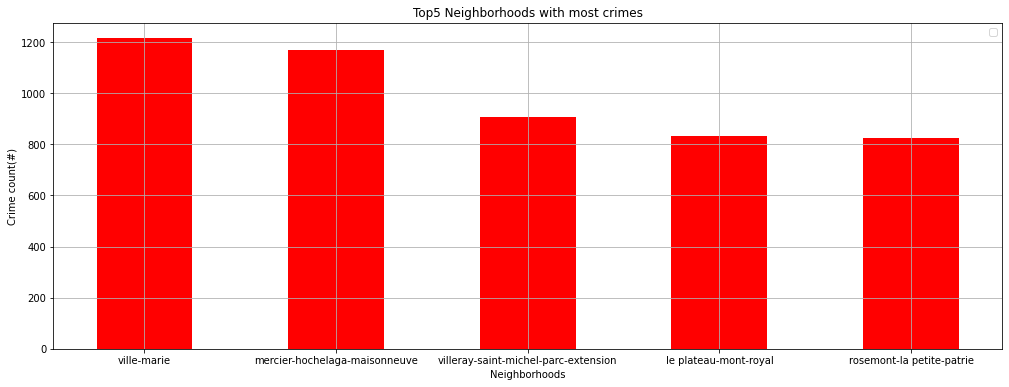

In [24]:
plt.figure(figsize=(17, 6))
X = dfDummyCrime['Neighborhood'].head(5)
X_axis = np.arange(len(X))
plt.title("Top5 Neighborhoods with most crimes")
plt.legend(labels = ['Total'])
plt.bar(dfDummyCrime.sort_values('Total',ascending=False)['Neighborhood'].head(5),dfDummyCrime.sort_values('Total',ascending=False)['Total'].head(5),color="red",align='center',width=0.5)
plt.grid()
plt.ylabel('Crime count(#)')
plt.xlabel('Neighborhoods')

Text(0.5, 0, 'Neighborhoods')

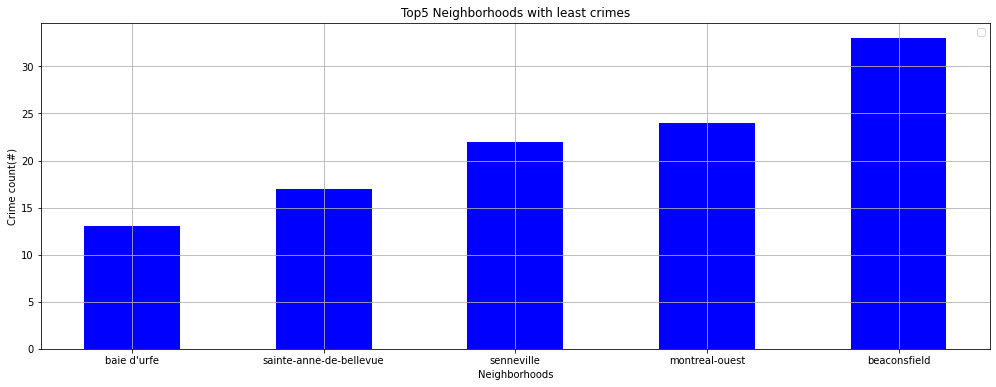

In [25]:
plt.figure(figsize=(17, 6))
X = dfDummyCrime['Neighborhood'].head(5)
X_axis = np.arange(len(X))
plt.title("Top5 Neighborhoods with least crimes")
plt.legend(labels = ['Total'])
plt.bar(dfDummyCrime.sort_values('Total',ascending=True)['Neighborhood'].head(5),dfDummyCrime.sort_values('Total',ascending=True)['Total'].head(5),color="blue",align='center',width=0.5)
plt.grid()
plt.ylabel('Crime count(#)')
plt.xlabel('Neighborhoods')

<h3>
For our top 5, lets have it breaked down into categories.
<h3>


Text(0.5, 0, 'Neighborhoods')

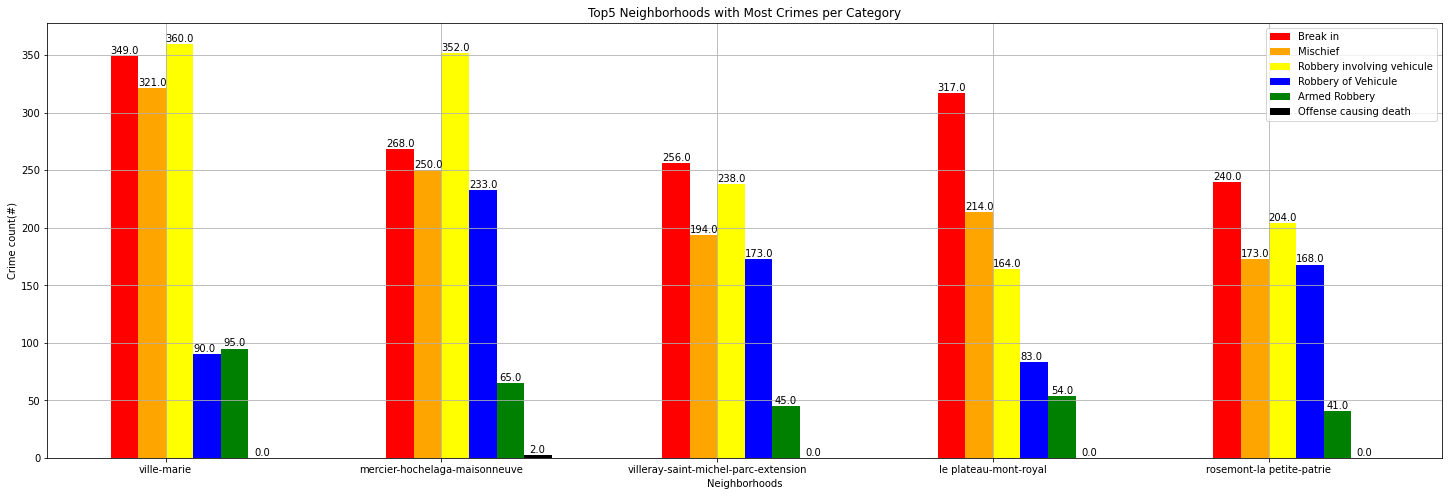

In [26]:
plt.figure(figsize=(25, 8))
plt.title("Top5 Neighborhoods with Most Crimes per Category")
plt.legend(labels = ['Total'])
plt.bar(X_axis - 0.2,dfDummyCrime['Break in'].head(5), color="red",align='edge',width=0.1 , label='Break in')
plt.bar(X_axis - 0.1,dfDummyCrime['Mischief'].head(5),color="orange",align='edge',width=0.1, label='Mischief')
plt.bar(X_axis,dfDummyCrime['Robbery involving vehicule'].head(5),color="Yellow",align='edge',width=0.1, label='Robbery involving vehicule')
plt.bar(X_axis + 0.1,dfDummyCrime['Robbery of Vehicule'].head(5),color="Blue",align='edge',width=0.1, label='Robbery of Vehicule')
plt.bar(X_axis + 0.2,dfDummyCrime['Armed Robbery'].head(5),color="Green",align='edge',width=0.1, label='Armed Robbery')
plt.bar(X_axis + 0.3,dfDummyCrime['Offense causing death'].head(5),color="Black",align='edge',width=0.1, label='Offense causing death')
for index, value in enumerate(dfDummyCrime['Break in'].head(5)):
    plt.text(index-0.20,value+2, str(value))
for index, value in enumerate(dfDummyCrime['Mischief'].head(5)):
    plt.text(index-0.10,value+2, str(value))
for index, value in enumerate(dfDummyCrime['Robbery involving vehicule'].head(5)):
    plt.text(index+0,value+2, str(value))
for index, value in enumerate(dfDummyCrime['Robbery of Vehicule'].head(5)):
    plt.text(index+0.10,value+2, str(value))
for index, value in enumerate(dfDummyCrime['Armed Robbery'].head(5)):
    plt.text(index+0.21,value+2, str(value))
for index, value in enumerate(dfDummyCrime['Offense causing death'].head(5)):
    plt.text(index+0.32,value+2, str(value))
plt.xticks(X_axis,X)
plt.legend()
plt.grid()
plt.ylabel('Crime count(#)')
plt.xlabel('Neighborhoods')

<h3>
After arranging the dataframe, let's see the crimes on the map.
<h3>


In [27]:
map = show_choropleth_map(geo_data=geojson,
                    dataframe=dfDummyCrime,
                    columns=['Neighborhood', 'Total'],
                    legend_name='Crimes',
                    color='OrRd'
                    )
plugins.ScrollZoomToggler().add_to(map)
map

<h3>
Here we will start working on our census dataframe. The census data covers a wide variety of demographics stats, well broken down into neighborhoods. The only downside is the data for being slightly stale(2016). We felt it is still realistic with the other data sets.
<h3>
<h3>
Population, Densite and real estate average pricing are taken for the purpose of this analysis.
<h3>

In [28]:
dfMtlPopulation = pd.read_excel("MontrealStatistique.XLS", sheet_name=2, header=2, usecols=[0,1,5])
dfMtlPopulation.columns = ['Neighborhood','Population','Densite']
dfMtlPopulation = dfMtlPopulation[(dfMtlPopulation["Neighborhood"] != 'AGGLOMÉRATION DE MONTRÉAL') & (dfMtlPopulation["Neighborhood"] != 'Ville de Montréal') & (dfMtlPopulation["Neighborhood"] != 'Autres villes') & (dfMtlPopulation["Neighborhood"] != 'L\'Île-Dorval')] 
dfMtlPopulation = dfMtlPopulation.reset_index(drop=True)
dfMtlPopulation = dfMtlPopulation.iloc[:33]
for x,row in enumerate(dfMtlPopulation.iterrows()):
    dfMtlPopulation.at[x,"Neighborhood"] = unidecode.unidecode(dfMtlPopulation.at[x,"Neighborhood"].lower())
    if dfMtlPopulation.at[x,"Neighborhood"] == 'baie-d\'urfe':
        dfMtlPopulation.at[x,"Neighborhood"] = 'baie d\'urfe'
    if dfMtlPopulation.at[x,"Neighborhood"] == 'dollard-des ormeaux':
        dfMtlPopulation.at[x,"Neighborhood"] = 'dollard-des-ormeaux'


dfMtlRealEstateAVG = pd.read_excel("MontrealStatistique.XLS", sheet_name=22, header=2, usecols=[0,7])
dfMtlRealEstateAVG.columns = ['Neighborhood','Price']
dfMtlRealEstateAVG = dfMtlRealEstateAVG[(dfMtlRealEstateAVG["Neighborhood"] != 'AGGLOMÉRATION DE MONTRÉAL') & (dfMtlRealEstateAVG["Neighborhood"] != 'Ville de Montréal') & (dfMtlRealEstateAVG["Neighborhood"] != 'Autres villes') & (dfMtlRealEstateAVG["Neighborhood"] != 'L\'Île-Dorval')] 
dfMtlRealEstateAVG = dfMtlRealEstateAVG.reset_index(drop=True)
dfMtlRealEstateAVG = dfMtlRealEstateAVG.iloc[:33]
for x,row in enumerate(dfMtlRealEstateAVG.iterrows()):
    dfMtlRealEstateAVG.at[x,"Neighborhood"] = unidecode.unidecode(dfMtlRealEstateAVG.at[x,"Neighborhood"].lower())
    if dfMtlRealEstateAVG.at[x,"Neighborhood"] == 'baie-d\'urfe':
        dfMtlRealEstateAVG.at[x,"Neighborhood"] = 'baie d\'urfe'
    if dfMtlRealEstateAVG.at[x,"Neighborhood"] == 'dollard-des ormeaux':
        dfMtlRealEstateAVG.at[x,"Neighborhood"] = 'dollard-des-ormeaux'
        

dfMTLCensus = pd.merge(dfMtlPopulation,dfMtlRealEstateAVG,how='left',on='Neighborhood')

In [29]:
print('Top5 Montreal Price')
print(dfMTLCensus.sort_values(ignore_index=True,by='Price',ascending=False, axis=0).head(5)[['Neighborhood','Price']])
print('\n')

print('Top5 Montreal Population')
print(dfMTLCensus.sort_values(ignore_index=True,by='Population',ascending=False, axis=0).head(5)[['Neighborhood','Population']])
print('\n')


Top5 Montreal Price
  Neighborhood    Price
0    westmount  1425737
1    hampstead  1147558
2   mont-royal  1017819
3   senneville   982011
4    outremont   896722


Top5 Montreal Population
                           Neighborhood  Population
0   cote-des-neiges-notre-dame-de-grace    166520.0
1  villeray-saint-michel-parc-extension    143853.0
2             rosemont-la petite-patrie    139590.0
3         mercier-hochelaga-maisonneuve    136024.0
4                 ahuntsic-cartierville    134245.0




<h3>
Montreal map breakdown of the population(in 2016!) 
<h3>

In [30]:
map = show_choropleth_map(geo_data=geojson,
                    dataframe=dfMTLCensus,
                    columns=['Neighborhood', 'Population'],
                    legend_name='Population',
                    color='BuPu'
                    )
plugins.ScrollZoomToggler().add_to(map)
map


<h3>
Here we do a correlation analysis of our different datasets. We want to see how one feature correlates with another.
<h3>

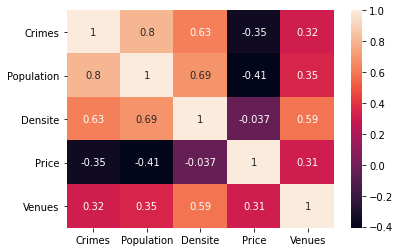

In [31]:
dfTest = pd.merge(left=dfMTLCensus, right=dfMtlVenuesCount,how='left',on='Neighborhood' )
dfTest.rename({"Total":"Venues"},axis='columns',errors="raise",inplace=True)
dfTest = pd.merge(left=dfDummyCrime[['Neighborhood','Total']],right=dfTest,how='left',on='Neighborhood')


dfTest.rename({"Total":"Crimes"},axis='columns',errors="raise",inplace=True)

dfTest = dfTest.sort_values(by='Neighborhood', ascending=True)
dfTest.drop(columns=['Neighborhood'],inplace=True)
dfTest['Crimes'] = dfTest['Crimes'].astype('int64')
dfTest['Price'] = dfTest['Price'].astype('float')
corrMatrix = dfTest.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

<h3>
Montreal map breakdown of the density(in 2016!) 
<h3>

In [32]:
map = show_choropleth_map(geo_data=geojson,
                    dataframe=dfMTLCensus,
                    columns=['Neighborhood', 'Densite'],
                    legend_name='Densite',
                    color='BuPu'
                    )
plugins.ScrollZoomToggler().add_to(map)
map

<h3>
Montreal map breakdown of the real estate price average (in 2016!) 
<h3>

In [33]:
map = show_choropleth_map(geo_data=geojson,
                    dataframe=dfMTLCensus,
                    columns=['Neighborhood', 'Price'],
                    legend_name='Price',
                    color='PuBu'
                    )
plugins.ScrollZoomToggler().add_to(map)
map

<h3>
As part of our clustering, we want to prepare the venues data in dummy manner to work with our KMeans algorithm. 
<h3>

In [34]:
dfMtlGroupedVenues_cluster = dfMtlGroupedVenues.drop(axis=0, columns='Neighborhood')
dfMtlGroupedVenues_cluster

African Restaurant  Airport  Airport Lounge  Airport Service  \
0                    0        0               0                0   
1                    0        0               0                0   
2                    0        0               0                0   
3                    0        0               0                0   
4                    0        0               0                0   
5                    0        0               0                0   
6                    0        0               0                0   
7                    0        2               5                3   
8                    1        0               0                0   
9                    0        0               0                0   
10                   0        0               0                0   
11                   0        0               1                0   
12                   0        0               0                0   
13                   0        0               0                0   
14                   0        0               0                0   
15                   0        0               0                0   
16                   0        0               0                0   
17                   0        0               0                0   
18                   0        0               0                0   
19                   0        0               0                0   
20                   0        0               0                0   
21                   0        0               0                0   
22                   0        0               0                0   
23                   0        0               0                0   
24                   0        0               0                0   
25                   0        0               0                0   
26                   0        0               0                0   
27                   0        0               0                0   
28                   0        0               0                0   
29                   0        0               0                0   
30                   0        0               0                0   
31                   0        0               0                0   
32                   0        0               0                0   

    American Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                     0            0           0                    0   
1                     1            0           0                    1   
2                     1            0           0                    0   
3                     1            1           0                    0   
4                     0            1           1                    0   
5                     1            1           0                    1   
6                     0            0           0                    0   
7                     0            0           0                    0   
8                     0            0           0                    0   
9                     1            0           0                    0   
10                    0            0           0                    0   
11                    0            0           0                    0   
12                    0            0           0                    0   
13                    0            0           0                    0   
14                    0            0           1                    0   
15                    1            0           0                    1   
16                    0            0           1                    0   
17                    0            0           0                    0   
18                    0            0           0                    0   
19                    0            1           0                    0   
20                    0            0           1                    0   
21                    0            0           0                    1   
22          

<h3>
To insure we get the optimal count of cluster, we loop the KMeans processes with a different cluster count.
We then analyze the inertia of each cluster count, from 1 to 11. Thru the elbow method, we think 3 clusters
works well for our context.
<h3>

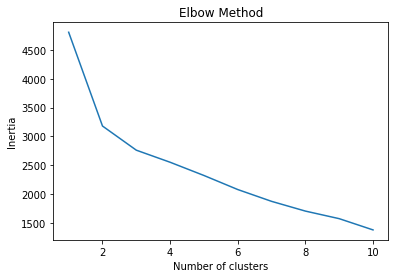

In [35]:
tabKInert = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 0)
    kmeans.fit(dfMtlGroupedVenues_cluster)
    tabKInert.append(kmeans.inertia_)
plt.plot(range(1,11), tabKInert)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

<h3>
Let's proceed with 3 clusters and append the cluster labels to each datasets and the neighborhoods.
<h3>

In [36]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 0)
kmeans.fit(dfMtlGroupedVenues_cluster)
dfMtlGroupedVenuesLatLong = dfMtlGroupedVenues
dfMtlGroupedVenuesLatLong['Cluster'] = kmeans.labels_[0:33]

In [37]:
#dfCrimeDummyLatLong = dfCrimeDummy.merge(dfMtlPos, left_on='Neighborhood', right_on='Boroughs')
#dfCrimeDummyLatLong = dfCrimeDummyLatLong.drop(axis=0, columns='Boroughs')
#dfCrimeDummyLatLong = dfCrimeDummyLatLong.drop(axis=0, columns='Type')
dfMtlGroupedVenuesLatLong = dfMtlGroupedVenuesLatLong.merge(dfMtlPos, left_on='Neighborhood', right_on='Boroughs')
dfMtlGroupedVenuesLatLong = dfMtlGroupedVenuesLatLong.drop(axis=0, columns='Boroughs')
dfMtlGroupedVenuesLatLong = dfMtlGroupedVenuesLatLong.drop(axis=0, columns='Type')

In [38]:
#dfCrimeDummy.to_excel(r'MontrealCrimeMeanAndCluster.xlsx')
#dfCrimeDummyLatLong
dfMtlGroupedVenuesLatLong.head(5)

Neighborhood  African Restaurant  Airport  \
0                ahuntsic-cartierville                   0        0   
1                                anjou                   0        0   
2                          baie d'urfe                   0        0   
3                         beaconsfield                   0        0   
4  cote-des-neiges-notre-dame-de-grace                   0        0   

   Airport Lounge  Airport Service  American Restaurant  Art Gallery  \
0               0                0                    0            0   
1               0                0                    1            0   
2               0                0                    1            0   
3               0                0                    1            1   
4               0                0                    0            1   

   Art Museum  Arts & Crafts Store  Asian Restaurant  ...  \
0           0                    0                 1  ...   
1           0                    1                 0  ...   
2           0                    0                 0  ...   
3           0                    0                 0  ...   
4           1                    0                 0  ...   

   Vietnamese Restaurant  Warehouse Store  Wine Bar  Wine Shop  Yoga Studio  \
0                      0                0         1          0            0   
1                      1                1         0          0            0   
2                      0                0         0          0            0   
3                      1                0         0          0            0   
4                      3                0         0          0            1   

   Zoo  Zoo Exhibit  Cluster        Lat       Long  
0    0            0        0  45.544743 -73.668126  
1    0            0        2  45.615958 -73.569351  
2    1            0        1  45.416456 -73.916080  
3    0            0        2  45.430931 -73.868283  
4    0            0        0  45.491151 -73.632653  

[5 rows x 203 columns]

<h3>
Our clusters displayed on the map. We can see the spread and proximity of some neighborhoods within clusters.
<h3>

In [39]:
map = folium.Map(location=[45.5017, -73.5673], zoom_start=11)
def style_function(feature):
    return { 'color': 'grey', 'fillOpacity': 0.2, }

plugins.ScrollZoomToggler().add_to(map)
folium.GeoJson("MontrealGeoShape.geojson", style_function=style_function, name='geojson').add_to(map)

#Add venues to map        
for borough,lat,long,cluster in zip(dfMtlGroupedVenuesLatLong['Neighborhood'],dfMtlGroupedVenuesLatLong['Lat'],dfMtlGroupedVenuesLatLong['Long'],dfMtlGroupedVenuesLatLong['Cluster']):
    label = folium.Popup((borough+' - Cluster'+str(cluster)), parse_html=True)
    if cluster == 0:
        color='red'
    elif cluster == 1:
        color='blue'
    elif cluster == 2:
        color='black'
    elif cluster == 3:
        color='purple'
    elif cluster == 4:
        color='pink'
    elif cluster == 5:
        color='lightblue'
    elif cluster == 6:
        color='white'
    folium.Marker(
        [lat, long],
        popup=label,
        icon=folium.Icon(color=color),
        parse_html=False).add_to(map) 
map

In [40]:
neighborhoods_venues_sorted['Cluster'] = kmeans.labels_[0:33]

In [41]:
neighborhoods_venues_sorted.sort_values('Cluster', ascending=True)

Neighborhood 1st Most Common Venue  \
0                      ahuntsic-cartierville                  Café   
30                               ville-marie                  Café   
29                                    verdun                  Café   
24                 rosemont-la petite-patrie                  Café   
20                                 outremont                  Café   
31      villeray-saint-michel-parc-extension                  Café   
14                              le sud-ouest                  Café   
13                     le plateau-mont-royal                  Café   
16                                mont-royal                  Café   
4        cote-des-neiges-notre-dame-de-grace                  Café   
32                                 westmount                  Café   
11                                   lachine  Fast Food Restaurant   
12                                   lasalle           Coffee Shop   
2                                baie d'urfe              Pharmacy   
15             mercier-hochelaga-maisonneuve          Liquor Store   
5                             cote-saint-luc     Indian Restaurant   
28                                senneville                   Bar   
18                             montreal-nord              Pharmacy   
19                            montreal-ouest                  Café   
8                                  hampstead                   Pub   
10             l'ile-bizard-sainte-genevieve        Ice Cream Shop   
27                   sainte-anne-de-bellevue         Grocery Store   
26                             saint-leonard                  Park   
1                                      anjou              Pharmacy   
25                             saint-laurent           Coffee Shop   
21                       pierrefonds-roxboro    Italian Restaurant   
23  riviere-des-prairies-pointe-aux-trembles           Coffee Shop   
22                             pointe-claire            Restaurant   
17                              montreal-est              Pharmacy   
6                        dollard-des-ormeaux    Italian Restaurant   
7                                     dorval           Coffee Shop   
3                               beaconsfield           Coffee Shop   
9                                   kirkland           Coffee Shop   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0                 Bakery          Liquor Store        Breakfast Spot   
30                  Park            Restaurant                Bakery   
29                  Park            Restaurant                Bakery   
24                Bakery                  Park     French Restaurant   
20                Bakery                  Park     French Restaurant   
31                Bakery                  Park           Coffee Shop   
14                  Park                Bakery            Restaurant   
13                Bakery                  Park            Restaurant   
16                Bakery                  Park            Restaurant   
4                   Park        Ice Cream Shop                Bakery   
32            Restaurant                  Park         Grocery Store   
11                  Café           Coffee Shop    Italian Restaurant   
12    Italian Restaurant                  Café           Pizza Place   
2   Fast Food Restaurant           Coffee Shop            Restaurant   
15                  Park        Sandwich Place                Bakery   
5                   Café        Breakfast Spot                  Park   
28    Italian Restaurant          Burger Joint                  Park   
18        Sandwich Place                Bakery           Supermarket   
19           Pizza Place    Italian Restaurant                  Bank   
8            Coffee Shop                  Park                  Café   
10                  Park              Pharmacy        Breakfast Spot   
27           Coffee Shop          Liquor Store        Sandwich Plac

In [42]:
%%capture
dfMTLCensus['Cluster'] = kmeans.labels_[0:33]
dfDummyCrime['Cluster'] = kmeans.labels_[0:33]

dfCrimeAVG = dfDummyCrime[['Cluster','Total']]
dfCrimeAVG['Total'] = dfCrimeAVG['Total'].astype(int)
#dfCrimeAVG = dfCrimeAVG.groupby('Cluster').mean().reset_index()
#neighborhoods_venues_sorted[['Neighborhood','Cluster']]

<h3>
We are ready to prepare the data for boxplots for the different datasets.
<h3>

In [43]:
%%capture

dfTemp = dfMTLCensus[['Cluster','Price']]
dfTemp['Price'] = dfTemp['Price'].astype(int)
dfTemp = dfTemp.groupby('Cluster').mean()
dfTemp = dfTemp.reset_index()

dfMtlAvgCensus = dfTemp
dfTemp = dfMTLCensus[['Cluster','Population']]
dfTemp['Population'] = dfTemp['Population'].astype(int)
dfTemp = dfTemp.groupby('Cluster').mean()
dfTemp = dfTemp.reset_index()
dfMtlAvgCensus = pd.merge(dfMtlAvgCensus,dfTemp,how='left',on='Cluster')

dfMtlAvgCensus['Price'] = dfMtlAvgCensus['Price'].astype('int64')
dfMtlAvgCensus['Population'] = dfMtlAvgCensus['Population'].astype('int64')

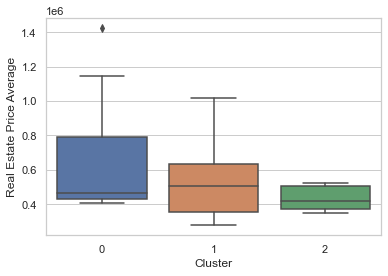

In [44]:
#cluster_colors=["#FF0000","#009BFF","#000000"]

sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="Cluster", y="Price", 
                 data=dfMTLCensus[['Cluster','Price']]).set(ylabel='Real Estate Price Average')

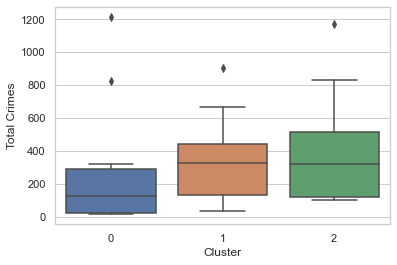

In [45]:
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.boxplot(x="Cluster", y="Total",
                 data=dfDummyCrime[['Cluster','Total']]).set(ylabel='Total Crimes')

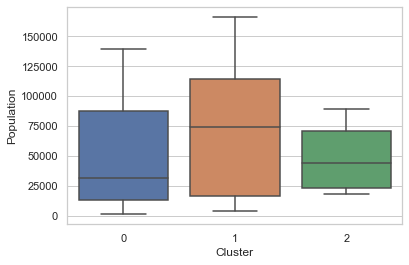

In [46]:

sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.boxplot(x="Cluster", y="Population",
                 data=dfMTLCensus[['Cluster','Population']]).set(ylabel='Population')

In [47]:
# plt.rcdefaults()
# fig, ax = plt.subplots()
# cluster = dfCrimeAVG['Cluster']
# y_pos = np.arange(len(dfCrimeAVG['Cluster']))
# avgCrimes = dfCrimeAVG['Total']
# #error = np.random.rand(len(dfCrimeAVG['Cluster']))
# ax.barh(y_pos, avgCrimes,  align='center',color='orange')
# ax.set_yticks(y_pos)
# ax.set_yticklabels(cluster)
# ax.invert_yaxis()  # labels read top-to-bottom
# ax.set_xlabel('Average crime')
# ax.set_title('AVG Crime per Cluster')
# plt.show()

# plt.rcdefaults()
# fig, ax = plt.subplots()
# cluster = dfMtlAvgCensus['Cluster']
# y_pos = np.arange(len(dfMtlAvgCensus['Cluster']))
# avgCrimes = dfMtlAvgCensus['Population']
# #error = np.random.rand(len(dfCrimeAVG['Cluster']))
# ax.barh(y_pos, avgCrimes,  align='center',color='green')
# ax.set_yticks(y_pos)
# ax.set_yticklabels(cluster)
# ax.invert_yaxis()  # labels read top-to-bottom
# ax.set_xlabel('Average population')
# ax.set_title('AVG Population per Cluster')
# plt.show()


# plt.rcdefaults()
# fig, ax = plt.subplots()
# cluster = dfMtlAvgCensus['Cluster']
# y_pos = np.arange(len(dfMtlAvgCensus['Cluster']))
# avgCrimes = dfMtlAvgCensus['Price'].astype('int64')
# #error = np.random.rand(len(dfCrimeAVG['Cluster']))
# ax.barh(y_pos, avgCrimes, align='center',color='purple')
# ax.set_yticks(y_pos)
# ax.set_yticklabels(cluster)
# ax.invert_yaxis()  # labels read top-to-bottom
# ax.set_xlabel('Average price')
# ax.set_title('AVG Price per Cluster')
# ax.ticklabel_format(style='plain', axis='x')
# plt.show()